# video.ipynb — 用 tracking/annotation 生成可观看的视频

这个 notebook **不会生成原始像素视频**（数据里没有原始视频帧）。它会把 `train_tracking/` 或 `test_tracking/` 中的关键点 `(x,y)` 轨迹渲染成可播放的 **pose 可视化视频**，并可选叠加 `train_annotation/` 的行为标签。

你只需要指定 `split`（train/test）和 `video_id`；`lab_id` 可以从 `train.csv/test.csv` 推断，或在同一 `video_id` 出现在多个 lab 子目录时手动选择。

## 1. 配置路径与依赖（VS Code 运行环境检查）

- 数据根目录：`./data`
- 输出目录：`./outputs`
- 依赖：pandas / numpy / matplotlib
- 导出 mp4：需要系统可执行文件 `ffmpeg`（你已经装过的话这里会检测到）
- 如果没有 ffmpeg：会降级导出 gif（需要 Pillow）

In [2]:
from __future__ import annotations

from pathlib import Path
import shutil
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_ROOT = Path("..\\data")
OUT_DIR = Path("..\\outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

HAS_FFMPEG = shutil.which("ffmpeg") is not None
print(f"DATA_ROOT: {DATA_ROOT}")
print(f"OUT_DIR:   {OUT_DIR}")
print(f"ffmpeg:    {'OK' if HAS_FFMPEG else 'NOT FOUND (will fallback to GIF if Pillow available)'}")

DATA_ROOT: ..\data
OUT_DIR:   ..\outputs
ffmpeg:    NOT FOUND (will fallback to GIF if Pillow available)


## 2. 读取 train.csv/test.csv：列解析与视频筛选器（按 video_id / lab_id）

下面会读取元数据，并提供一个简单筛选函数：按 `lab_id`、行为关键词（在 `behaviors labeled` 字段里）、时长范围筛选候选 `video_id`。

In [3]:
train_meta = pd.read_csv(DATA_ROOT / "train.csv")
test_meta = pd.read_csv(DATA_ROOT / "test.csv")

print("train.csv shape:", train_meta.shape)
print("test.csv  shape:", test_meta.shape)

# 展示一些你可能关心的列（不同版本/导出格式列名可能稍有差异）
interesting = [
    "video_id",
    "lab_id",
    "frames per second",
    "video width",
    "video height",
    "arena width (cm)",
    "arena height (cm)",
    "arena shape",
    "arena type",
    "body parts tracked",
    "behaviors labeled",
    "video duration (sec)",
]

def _present_cols(df: pd.DataFrame, cols: list[str]) -> list[str]:
    return [c for c in cols if c in df.columns]

print("\nAvailable interesting columns (train):")
print(_present_cols(train_meta, interesting))


def filter_videos(
    split: str = "train",
    lab_id: str | None = None,
    behavior_keyword: str | None = None,
    min_duration_sec: float | None = None,
    max_duration_sec: float | None = None,
    limit: int = 20,
) -> pd.DataFrame:
    """返回候选视频列表（包含 video_id/lab_id 和少量描述字段）。"""
    meta = train_meta if split == "train" else test_meta

    df = meta.copy()
    if lab_id is not None and "lab_id" in df.columns:
        df = df[df["lab_id"] == lab_id]

    if behavior_keyword is not None and "behaviors labeled" in df.columns:
        # behaviors labeled 通常是字符串列表/逗号分隔等，这里用 contains 做最简单匹配
        df = df[df["behaviors labeled"].astype(str).str.contains(behavior_keyword, case=False, na=False)]

    if (min_duration_sec is not None or max_duration_sec is not None) and "video duration (sec)" in df.columns:
        dur = pd.to_numeric(df["video duration (sec)"], errors="coerce")
        if min_duration_sec is not None:
            df = df[dur >= float(min_duration_sec)]
        if max_duration_sec is not None:
            df = df[dur <= float(max_duration_sec)]

    show_cols = [c for c in [
        "video_id", "lab_id", "frames per second", "video duration (sec)",
        "arena shape", "body parts tracked", "behaviors labeled"
    ] if c in df.columns]

    return df[show_cols].head(limit)


# 示例：看一下某个 lab 的前 10 个视频
filter_videos(split="train", lab_id=None, limit=10)

train.csv shape: (8789, 38)
test.csv  shape: (1, 38)

Available interesting columns (train):
['video_id', 'lab_id']


video_id          lab_id
0    44566106  AdaptableSnail
1   143861384  AdaptableSnail
2   209576908  AdaptableSnail
3   278643799  AdaptableSnail
4   351967631  AdaptableSnail
5   355542626  AdaptableSnail
6   678426900  AdaptableSnail
7   705948978  AdaptableSnail
8   878123481  AdaptableSnail
9  1212811043  AdaptableSnail

## 3. 定位并加载某个 video_id 的 tracking 文件（train_tracking/ 或 test_tracking/）

tracking 文件结构：`data/{split}_tracking/{lab_id}/{video_id}.parquet`

如果同一个 `video_id` 在多个 `lab_id` 子目录里出现（少数情况会发生），下面会给出候选路径让你选择。

In [4]:
from typing import Tuple


def _as_int_video_id(video_id: str | int) -> str:
    # parquet 文件名是纯数字（示例：1212811043.parquet），这里统一转成字符串
    try:
        return str(int(video_id))
    except Exception:
        return str(video_id)


def find_tracking_paths(video_id: str | int, split: str = "train") -> list[Path]:
    video_id = _as_int_video_id(video_id)
    base = DATA_ROOT / ("train_tracking" if split == "train" else "test_tracking")
    # 目录结构固定为 {lab_id}/{video_id}.parquet，这里用 rglob 兼容少数不标准情况
    return sorted(base.rglob(f"{video_id}.parquet"))


def infer_lab_id_from_meta(video_id: str | int, split: str = "train") -> str | None:
    video_id = int(video_id)
    meta = train_meta if split == "train" else test_meta
    if "video_id" not in meta.columns or "lab_id" not in meta.columns:
        return None
    row = meta.loc[meta["video_id"] == video_id]
    if row.empty:
        return None
    # 一个 video_id 通常只有一个 lab_id
    return str(row.iloc[0]["lab_id"])


def load_tracking(
    video_id: str | int,
    split: str = "train",
    lab_id: str | None = None,
) -> Tuple[pd.DataFrame, str, Path]:
    """加载 tracking parquet，返回 (df, resolved_lab_id, path)。"""
    video_id_str = _as_int_video_id(video_id)

    if lab_id is None:
        lab_id = infer_lab_id_from_meta(video_id_str, split=split)

    if lab_id is not None:
        candidate = DATA_ROOT / ("train_tracking" if split == "train" else "test_tracking") / lab_id / f"{video_id_str}.parquet"
        if candidate.exists():
            path = candidate
            resolved_lab = lab_id
        else:
            paths = find_tracking_paths(video_id_str, split=split)
            if not paths:
                raise FileNotFoundError(f"No tracking parquet found for video_id={video_id_str} in split={split}")
            # 如果推断的 lab_id 不对，就按搜索结果选择
            path = paths[0]
            resolved_lab = path.parent.name
    else:
        paths = find_tracking_paths(video_id_str, split=split)
        if not paths:
            raise FileNotFoundError(f"No tracking parquet found for video_id={video_id_str} in split={split}")
        if len(paths) > 1:
            print("Multiple tracking files found for this video_id:")
            for i, p in enumerate(paths):
                print(f"  [{i}] {p}")
            print("Using the first one by default; pass lab_id=... to select explicitly.")
        path = paths[0]
        resolved_lab = path.parent.name

    df = pd.read_parquet(path)

    required = {"video_frame", "mouse_id", "bodypart", "x", "y"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Tracking parquet missing columns: {sorted(missing)}. Got columns={list(df.columns)}")

    # 规范类型
    df = df.copy()
    df["video_frame"] = pd.to_numeric(df["video_frame"], errors="coerce").astype("Int64")
    df["mouse_id"] = pd.to_numeric(df["mouse_id"], errors="coerce").astype("Int64")
    df["bodypart"] = df["bodypart"].astype(str)
    df["x"] = pd.to_numeric(df["x"], errors="coerce")
    df["y"] = pd.to_numeric(df["y"], errors="coerce")

    df = df.dropna(subset=["video_frame", "mouse_id"])
    df["video_frame"] = df["video_frame"].astype(int)
    df["mouse_id"] = df["mouse_id"].astype(int)

    return df, resolved_lab, path


# ====== 在这里设置你要看的视频 ======
SPLIT = "train"   # 'train' 或 'test'
VIDEO_ID = 1212811043  # 改成你想看的 video_id（数字即可）
LAB_ID = None      # 一般可留空（会从 CSV 推断或从文件路径推断）

tracking_df, RESOLVED_LAB_ID, tracking_path = load_tracking(VIDEO_ID, split=SPLIT, lab_id=LAB_ID)
print("Loaded:", tracking_path)
print("Resolved lab_id:", RESOLVED_LAB_ID)
print(tracking_df.head())
print("frames:", tracking_df["video_frame"].min(), "->", tracking_df["video_frame"].max())
print("mice:", sorted(tracking_df["mouse_id"].unique()))
print("bodyparts (sample):", tracking_df["bodypart"].value_counts().head(10).index.tolist())

Loaded: ..\data\train_tracking\AdaptableSnail\1212811043.parquet
Resolved lab_id: AdaptableSnail
   video_frame  mouse_id       bodypart           x           y
0            0         1    body_center  496.187012  376.475006
1            0         1       ear_left  494.059998  343.924011
2            0         1      ear_right  518.765015  367.362000
3            0         1   lateral_left  474.536987  370.563995
4            0         1  lateral_right  505.825012  394.937012
frames: 0 -> 89975
mice: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
bodyparts (sample): ['body_center', 'lateral_left', 'lateral_right', 'ear_left', 'ear_right', 'tail_base', 'tail_midpoint', 'nose', 'tail_tip', 'neck']


## 4. tracking 数据整形：按帧聚合、按鼠/关键点透视（pivot）

为了渲染更快，我们会：
- 建一个索引 `[(video_frame, mouse_id, bodypart) -> (x,y)]`
- 自动检测 bodypart 列表
- 根据 tracking 的分位数估计坐标轴范围（避免极端离群点影响画面）

In [4]:
def prepare_tracking_index(df: pd.DataFrame) -> tuple[pd.DataFrame, list[int], list[str]]:
    """返回 (indexed_df, mouse_ids, bodyparts)。indexed_df 的 index 为 (video_frame, mouse_id, bodypart)。"""
    df2 = df[["video_frame", "mouse_id", "bodypart", "x", "y"]].copy()
    df2 = df2.dropna(subset=["video_frame", "mouse_id", "bodypart"])

    # 有些数据会重复同一帧/鼠/点（多次记录），这里取均值，避免 pivot 报错
    df2 = (
        df2.groupby(["video_frame", "mouse_id", "bodypart"], as_index=False)[["x", "y"]]
        .mean(numeric_only=True)
    )

    indexed = df2.set_index(["video_frame", "mouse_id", "bodypart"]).sort_index()
    mouse_ids = sorted(df2["mouse_id"].unique().tolist())
    bodyparts = sorted(df2["bodypart"].unique().tolist())
    return indexed, mouse_ids, bodyparts


def estimate_axis_limits(
    df: pd.DataFrame,
    meta_row: pd.Series | None = None,
    q_low: float = 0.01,
    q_high: float = 0.99,
) -> tuple[tuple[float, float], tuple[float, float]]:
    """优先用 metadata 的 video width/height；否则用 tracking 分位数范围。"""
    if meta_row is not None:
        w = meta_row.get("video width", None)
        h = meta_row.get("video height", None)
        try:
            w = float(w)
            h = float(h)
            if np.isfinite(w) and np.isfinite(h) and w > 0 and h > 0:
                return (0.0, w), (0.0, h)
        except Exception:
            pass

    x = pd.to_numeric(df["x"], errors="coerce")
    y = pd.to_numeric(df["y"], errors="coerce")
    x0, x1 = x.quantile(q_low), x.quantile(q_high)
    y0, y1 = y.quantile(q_low), y.quantile(q_high)
    # 轻微 padding
    dx = float(x1 - x0) if np.isfinite(x1 - x0) else 1.0
    dy = float(y1 - y0) if np.isfinite(y1 - y0) else 1.0
    pad_x = 0.05 * dx
    pad_y = 0.05 * dy
    return (float(x0 - pad_x), float(x1 + pad_x)), (float(y0 - pad_y), float(y1 + pad_y))


meta = train_meta if SPLIT == "train" else test_meta
meta_row = None
if "video_id" in meta.columns:
    r = meta.loc[meta["video_id"] == int(VIDEO_ID)]
    if not r.empty:
        meta_row = r.iloc[0]

indexed_tracking, MOUSE_IDS, BODYPARTS = prepare_tracking_index(tracking_df)
xlim, ylim = estimate_axis_limits(tracking_df, meta_row=meta_row)

print("mouse_ids:", MOUSE_IDS)
print("#bodyparts:", len(BODYPARTS))
print("xlim:", xlim)
print("ylim:", ylim)


def get_frame_points(frame_idx: int) -> dict[int, pd.DataFrame]:
    """返回 {mouse_id: DataFrame(bodypart,x,y)}，便于渲染。"""
    try:
        frame_slice = indexed_tracking.loc[frame_idx]
    except KeyError:
        return {}

    out: dict[int, pd.DataFrame] = {}
    # frame_slice index: (mouse_id, bodypart)
    for mouse_id in MOUSE_IDS:
        try:
            m = frame_slice.loc[mouse_id]
        except KeyError:
            continue
        m2 = m.reset_index().rename(columns={"index": "bodypart"})
        # m2 columns: bodypart, x, y
        out[mouse_id] = m2
    return out

mouse_ids: [1, 2, 3, 4]
#bodyparts: 10
xlim: (120.82780563354491, 804.9221730041505)
ylim: (-17.363200426101685, 630.8932020664215)


## 5. 可视化单帧：绘制 arena 边界（基于 metadata）+ 关键点散点

这里提供一个快速检查函数：输入 `frame_idx`，画出这一帧所有 mouse 的关键点散点。

说明：不同 lab 的 bodyparts 不一致，这里默认全部绘制；如果你想只画某些点，可以在函数参数里传 `bodyparts_subset`。

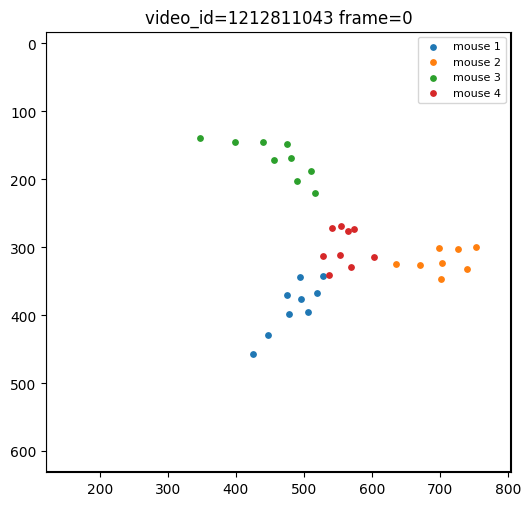

In [5]:
from matplotlib.patches import Rectangle, Circle


def _draw_arena(ax: plt.Axes, meta_row: pd.Series | None, xlim, ylim) -> None:
    # 最小实现：优先按 arena shape 猜测画个边界；否则画视频边界/坐标轴范围
    if meta_row is None:
        ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1] - xlim[0], ylim[1] - ylim[0], fill=False, linewidth=1.5))
        return

    shape = str(meta_row.get("arena shape", "")).lower()

    # 如果有 video width/height，就用它作为外框
    try:
        w = float(meta_row.get("video width", np.nan))
        h = float(meta_row.get("video height", np.nan))
    except Exception:
        w, h = np.nan, np.nan

    if np.isfinite(w) and np.isfinite(h) and w > 0 and h > 0:
        # 常见情况下视频像素边界就是可见范围
        if "circle" in shape or "round" in shape:
            r = min(w, h) / 2.0
            ax.add_patch(Circle((w / 2.0, h / 2.0), r, fill=False, linewidth=1.5))
        else:
            ax.add_patch(Rectangle((0, 0), w, h, fill=False, linewidth=1.5))
        return

    # 回退：按当前轴范围
    ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1] - xlim[0], ylim[1] - ylim[0], fill=False, linewidth=1.5))


def plot_frame(
    frame_idx: int,
    bodyparts_subset: list[str] | None = None,
    show_labels: bool = False,
    figsize=(6, 6),
):
    pts = get_frame_points(frame_idx)

    fig, ax = plt.subplots(figsize=figsize)
    _draw_arena(ax, meta_row, xlim, ylim)

    cmap = plt.get_cmap("tab10")
    for i, mouse_id in enumerate(MOUSE_IDS):
        if mouse_id not in pts:
            continue
        dfm = pts[mouse_id]
        if bodyparts_subset is not None:
            dfm = dfm[dfm["bodypart"].isin(bodyparts_subset)]

        ax.scatter(dfm["x"], dfm["y"], s=15, color=cmap(i % 10), label=f"mouse {mouse_id}")
        if show_labels:
            for _, r in dfm.iterrows():
                if pd.notna(r["x"]) and pd.notna(r["y"]):
                    ax.text(float(r["x"]), float(r["y"]), str(r["bodypart"]), fontsize=6)

    ax.set_title(f"video_id={VIDEO_ID} frame={frame_idx}")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()  # 图像坐标常见 y 向下
    ax.legend(loc="upper right", fontsize=8)
    plt.show()


# Quick preview：画一帧看看
preview_frame = int(tracking_df["video_frame"].min())
plot_frame(preview_frame, show_labels=False)

## 6. 生成动画预览（Matplotlib FuncAnimation）：Jupyter 内联播放

- 支持 `start/stop/stride`（抽帧加速）
- FPS：优先取 metadata 的 `frames per second`，也可手动指定
- 预览：用 HTML5 video 或 JSHTML 内联播放（取决于浏览器/VS Code notebook 支持）

In [6]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def _infer_fps(meta_row: pd.Series | None, fallback: float = 30.0) -> float:
    if meta_row is None:
        return float(fallback)
    v = meta_row.get("frames per second", None)
    try:
        v = float(v)
        if np.isfinite(v) and v > 0:
            return v
    except Exception:
        pass
    return float(fallback)


def make_animation(
    start_frame: int | None = None,
    stop_frame: int | None = None,
    stride: int = 2,
    out_fps: float | None = None,
    figsize=(6, 6),
    bodyparts_subset: list[str] | None = None,
):
    if start_frame is None:
        start_frame = int(tracking_df["video_frame"].min())
    if stop_frame is None:
        stop_frame = int(tracking_df["video_frame"].min()) + 300  # 默认先预览 300 帧

    frames = list(range(int(start_frame), int(stop_frame), int(stride)))
    if not frames:
        raise ValueError("No frames to render. Check start/stop/stride.")

    fps = float(out_fps) if out_fps is not None else _infer_fps(meta_row)

    fig, ax = plt.subplots(figsize=figsize)
    _draw_arena(ax, meta_row, xlim, ylim)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()

    cmap = plt.get_cmap("tab10")
    scatters = {}
    for i, mouse_id in enumerate(MOUSE_IDS):
        sc = ax.scatter([], [], s=15, color=cmap(i % 10), label=f"mouse {mouse_id}")
        scatters[mouse_id] = sc

    title = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top")
    ax.legend(loc="upper right", fontsize=8)

    def _update(frame_idx: int):
        pts = get_frame_points(frame_idx)
        for mouse_id in MOUSE_IDS:
            sc = scatters[mouse_id]
            if mouse_id not in pts:
                sc.set_offsets(np.empty((0, 2)))
                continue
            dfm = pts[mouse_id]
            if bodyparts_subset is not None:
                dfm = dfm[dfm["bodypart"].isin(bodyparts_subset)]
            xy = dfm[["x", "y"]].to_numpy(dtype=float)
            xy = xy[np.isfinite(xy).all(axis=1)]
            sc.set_offsets(xy)

        t = frame_idx / fps
        title.set_text(f"video_id={VIDEO_ID}  frame={frame_idx}  t={t:.2f}s")
        return [*scatters.values(), title]

    interval_ms = 1000.0 / fps
    anim = FuncAnimation(fig, _update, frames=frames, interval=interval_ms, blit=True)
    plt.close(fig)
    return anim


# 生成一个短预览（默认 300 帧，每 2 帧抽 1 帧）
anim = make_animation(start_frame=preview_frame, stop_frame=preview_frame + 300, stride=2)
HTML(anim.to_jshtml())

## 7. 导出 MP4（ffmpeg）与 GIF（Pillow）：输出到 ./outputs/

- `fmt='mp4'`：需要 `ffmpeg`
- `fmt='gif'`：需要 `Pillow`

导出函数会打印耗时与输出路径。

In [7]:
from matplotlib.animation import FFMpegWriter


def export_video(
    video_id: str | int,
    split: str,
    lab_id: str,
    start: int,
    stop: int,
    stride: int = 2,
    fmt: str = "mp4",
    out_fps: float | None = None,
    bodyparts_subset: list[str] | None = None,
) -> Path:
    """导出 pose 动画到 outputs/。返回输出文件路径。"""
    fps = float(out_fps) if out_fps is not None else _infer_fps(meta_row)

    stem = f"pose_{split}_{lab_id}_{_as_int_video_id(video_id)}_{start}-{stop}_s{stride}_fps{fps:g}"

    fmt = fmt.lower().strip(".")
    if fmt not in {"mp4", "gif"}:
        raise ValueError("fmt must be 'mp4' or 'gif'")

    if fmt == "mp4" and not HAS_FFMPEG:
        print("ffmpeg not found -> fallback to GIF (fmt='gif')")
        fmt = "gif"

    out_path = OUT_DIR / f"{stem}.{fmt}"

    anim = make_animation(
        start_frame=start,
        stop_frame=stop,
        stride=stride,
        out_fps=fps,
        bodyparts_subset=bodyparts_subset,
    )

    t0 = time.time()
    if fmt == "mp4":
        writer = FFMpegWriter(fps=fps, codec="libx264", bitrate=-1)
        anim.save(out_path, writer=writer)
    else:
        try:
            from matplotlib.animation import PillowWriter
        except Exception as e:
            raise RuntimeError("Export GIF requires Pillow. Try: pip install pillow") from e
        writer = PillowWriter(fps=fps)
        anim.save(out_path, writer=writer)

    dt = time.time() - t0
    print(f"Exported: {out_path}")
    print(f"Time: {dt:.2f}s")
    return out_path


# 示例：导出一个短片段（先短一点验证流程）
START_FRAME = preview_frame
END_FRAME = preview_frame + 300
STRIDE = 2
OUT_FPS = None  # None 表示从 metadata 推断

out_path = export_video(
    video_id=VIDEO_ID,
    split=SPLIT,
    lab_id=RESOLVED_LAB_ID,
    start=START_FRAME,
    stop=END_FRAME,
    stride=STRIDE,
    fmt="mp4",
    out_fps=OUT_FPS,
)
out_path

ffmpeg not found -> fallback to GIF (fmt='gif')
Exported: C:\Users\Windows11\Downloads\mice_social_action\outputs\pose_train_AdaptableSnail_1212811043_0-300_s2_fps30.gif
Time: 6.94s


WindowsPath('C:/Users/Windows11/Downloads/mice_social_action/outputs/pose_train_AdaptableSnail_1212811043_0-300_s2_fps30.gif')

## 8. 叠加 train_annotation/（可选）：在画面显示行为区间与 agent/target

仅对 `split='train'`：
- 自动定位 `data/train_annotation/{lab_id}/{video_id}.parquet`
- 在动画角落显示当前帧处于激活状态的行为（action/agent/target）

In [8]:
def find_annotation_paths(video_id: str | int, lab_id: str | None = None) -> list[Path]:
    video_id = _as_int_video_id(video_id)
    base = DATA_ROOT / "train_annotation"
    if lab_id is not None:
        p = base / lab_id / f"{video_id}.parquet"
        return [p] if p.exists() else []
    return sorted(base.rglob(f"{video_id}.parquet"))


def load_annotation(video_id: str | int, lab_id: str) -> tuple[pd.DataFrame | None, Path | None]:
    paths = find_annotation_paths(video_id, lab_id=lab_id)
    if not paths:
        return None, None
    path = paths[0]
    df = pd.read_parquet(path)

    required = {"agent_id", "target_id", "action", "start_frame", "stop_frame"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Annotation parquet missing columns: {sorted(missing)}. Got columns={list(df.columns)}")

    df = df.copy()
    df["agent_id"] = pd.to_numeric(df["agent_id"], errors="coerce").astype("Int64")
    df["target_id"] = pd.to_numeric(df["target_id"], errors="coerce").astype("Int64")
    df["start_frame"] = pd.to_numeric(df["start_frame"], errors="coerce").astype("Int64")
    df["stop_frame"] = pd.to_numeric(df["stop_frame"], errors="coerce").astype("Int64")
    df["action"] = df["action"].astype(str)
    df = df.dropna(subset=["start_frame", "stop_frame", "action"]).copy()
    df["start_frame"] = df["start_frame"].astype(int)
    df["stop_frame"] = df["stop_frame"].astype(int)

    return df, path


def prepare_annotation_overlay(ann: pd.DataFrame, frames: list[int]) -> dict[int, list[str]]:
    """把区间标注展开到需要渲染的帧集合上，返回 {frame: [text,...]}。"""
    frame_set = set(frames)
    overlay: dict[int, list[str]] = {f: [] for f in frames}

    # 只展开我们要渲染的 frames（避免全量区间展开过大）
    for _, r in ann.iterrows():
        s = int(r["start_frame"])
        e = int(r["stop_frame"])
        action = str(r["action"])
        agent = r.get("agent_id", None)
        target = r.get("target_id", None)
        label = f"{action}: agent {agent} -> target {target}"

        # 只对 frames 列表做一次线性扫描的交集（简单实现）
        for f in frames:
            if f < s:
                continue
            if f > e:
                break
            if f in frame_set:
                overlay[f].append(label)

    return overlay


# 可选：把 annotation 叠加到动画里
annotation_df = None
annotation_path = None
if SPLIT == "train":
    annotation_df, annotation_path = load_annotation(VIDEO_ID, lab_id=RESOLVED_LAB_ID)
    print("annotation:", annotation_path)
    if annotation_df is not None:
        display(annotation_df.head())


def make_animation_with_annotations(
    start_frame: int | None = None,
    stop_frame: int | None = None,
    stride: int = 2,
    out_fps: float | None = None,
    figsize=(6, 6),
    bodyparts_subset: list[str] | None = None,
):
    if annotation_df is None:
        return make_animation(start_frame, stop_frame, stride, out_fps, figsize, bodyparts_subset)

    if start_frame is None:
        start_frame = int(tracking_df["video_frame"].min())
    if stop_frame is None:
        stop_frame = int(tracking_df["video_frame"].min()) + 300

    frames = list(range(int(start_frame), int(stop_frame), int(stride)))
    fps = float(out_fps) if out_fps is not None else _infer_fps(meta_row)

    overlay_map = prepare_annotation_overlay(annotation_df, frames)

    fig, ax = plt.subplots(figsize=figsize)
    _draw_arena(ax, meta_row, xlim, ylim)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect("equal", adjustable="box")
    ax.invert_yaxis()

    cmap = plt.get_cmap("tab10")
    scatters = {}
    for i, mouse_id in enumerate(MOUSE_IDS):
        scatters[mouse_id] = ax.scatter([], [], s=15, color=cmap(i % 10), label=f"mouse {mouse_id}")

    hud = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top")
    ax.legend(loc="upper right", fontsize=8)

    def _update(frame_idx: int):
        pts = get_frame_points(frame_idx)
        for mouse_id in MOUSE_IDS:
            sc = scatters[mouse_id]
            if mouse_id not in pts:
                sc.set_offsets(np.empty((0, 2)))
                continue
            dfm = pts[mouse_id]
            if bodyparts_subset is not None:
                dfm = dfm[dfm["bodypart"].isin(bodyparts_subset)]
            xy = dfm[["x", "y"]].to_numpy(dtype=float)
            xy = xy[np.isfinite(xy).all(axis=1)]
            sc.set_offsets(xy)

        t = frame_idx / fps
        lines = [f"video_id={VIDEO_ID}", f"frame={frame_idx}", f"t={t:.2f}s"]
        active = overlay_map.get(frame_idx, [])
        if active:
            lines.append("---")
            lines.extend(active[:6])  # 太多会挡画面，这里最多显示 6 条
            if len(active) > 6:
                lines.append(f"(+{len(active) - 6} more)")
        hud.set_text("\n".join(lines))
        return [*scatters.values(), hud]

    interval_ms = 1000.0 / fps
    anim = FuncAnimation(fig, _update, frames=frames, interval=interval_ms, blit=True)
    plt.close(fig)
    return anim


# 预览（带 annotation）
anim2 = make_animation_with_annotations(start_frame=preview_frame, stop_frame=preview_frame + 300, stride=2)
HTML(anim2.to_jshtml())

annotation: C:\Users\Windows11\Downloads\mice_social_action\data\train_annotation\AdaptableSnail\1212811043.parquet


agent_id  target_id action  start_frame  stop_frame
0         1          3  chase            2          54
1         1          3  chase          128         234
2         3          2  avoid          324         342
3         3          1  avoid          324         342
4         1          2  chase          942        1052

## 9. 批量生成：按 video_id 列表循环导出预览视频（带进度与容错）

适合你快速扫一批视频，看看 tracking 是否正常。缺失文件会自动跳过并汇总。

In [9]:
def batch_export(
    video_ids: list[int],
    split: str = "train",
    start_offset: int = 0,
    n_frames: int = 300,
    stride: int = 2,
    fmt: str = "mp4",
    out_fps: float | None = None,
) -> tuple[list[Path], list[tuple[int, str]]]:
    ok: list[Path] = []
    failed: list[tuple[int, str]] = []

    for k, vid in enumerate(video_ids, 1):
        try:
            df, lab, _ = load_tracking(vid, split=split, lab_id=None)
            # 更新全局对象（简单做法：复用上面写好的可视化函数）
            global tracking_df, RESOLVED_LAB_ID, indexed_tracking, MOUSE_IDS, BODYPARTS, meta_row, xlim, ylim
            tracking_df = df
            RESOLVED_LAB_ID = lab

            meta = train_meta if split == "train" else test_meta
            meta_row = None
            r = meta.loc[meta["video_id"] == int(vid)] if "video_id" in meta.columns else pd.DataFrame()
            if not r.empty:
                meta_row = r.iloc[0]

            indexed_tracking, MOUSE_IDS, BODYPARTS = prepare_tracking_index(tracking_df)
            xlim, ylim = estimate_axis_limits(tracking_df, meta_row=meta_row)

            start = int(tracking_df["video_frame"].min()) + int(start_offset)
            stop = start + int(n_frames)

            out_path = export_video(
                video_id=vid,
                split=split,
                lab_id=lab,
                start=start,
                stop=stop,
                stride=stride,
                fmt=fmt,
                out_fps=out_fps,
            )
            ok.append(out_path)
            print(f"[{k}/{len(video_ids)}] OK  video_id={vid}")
        except Exception as e:
            failed.append((int(vid), repr(e)))
            print(f"[{k}/{len(video_ids)}] FAIL video_id={vid}: {e}")

    return ok, failed


# 示例：从筛选器里取前 N 个视频批量导出
#candidates = filter_videos(split="train", lab_id=None, limit=5)
#vids = candidates["video_id"].astype(int).tolist() if "video_id" in candidates.columns else []

#ok_paths, failed_list = batch_export(
#    video_ids=vids,
#    split="train",
#    start_offset=0,
#    n_frames=300,
#    stride=2,
#    fmt="mp4",
#)

#print("\nSucceeded:")
#for p in ok_paths:
#    print(" ", p)

#print("\nFailed:")
#for vid, err in failed_list:
#    print(f"  {vid}: {err}")

ffmpeg not found -> fallback to GIF (fmt='gif')
Exported: C:\Users\Windows11\Downloads\mice_social_action\outputs\pose_train_AdaptableSnail_44566106_0-300_s2_fps30.gif
Time: 7.20s
[1/5] OK  video_id=44566106
ffmpeg not found -> fallback to GIF (fmt='gif')
Exported: C:\Users\Windows11\Downloads\mice_social_action\outputs\pose_train_AdaptableSnail_143861384_0-300_s2_fps30.gif
Time: 7.25s
[2/5] OK  video_id=143861384
ffmpeg not found -> fallback to GIF (fmt='gif')
Exported: C:\Users\Windows11\Downloads\mice_social_action\outputs\pose_train_AdaptableSnail_209576908_0-300_s2_fps30.gif
Time: 6.75s
[3/5] OK  video_id=209576908
ffmpeg not found -> fallback to GIF (fmt='gif')
Exported: C:\Users\Windows11\Downloads\mice_social_action\outputs\pose_train_AdaptableSnail_278643799_0-300_s2_fps30.gif
Time: 8.41s
[4/5] OK  video_id=278643799
ffmpeg not found -> fallback to GIF (fmt='gif')
Exported: C:\Users\Windows11\Downloads\mice_social_action\outputs\pose_train_AdaptableSnail_351967631_0-300_s2_fps

## 10. 行为图鉴生成器：为每个动作生成示例 GIF

该脚本会扫描所有训练集标注，为每一个唯一的行为（如 `attack`, `mount` 等）挑选最多 3 个片段，并生成以行为命名的 GIF 文件，保存在项目根目录的 `video/` 文件夹下。

In [10]:
import os
from pathlib import Path

# 1. 创建输出文件夹
VIDEO_OUT_DIR = Path("video")
VIDEO_OUT_DIR.mkdir(exist_ok=True)

# 2. 扫描所有 annotation 文件并按 action 收集片段
action_segments = {} # {action: [(video_id, lab_id, start, stop), ...]}

print("Scanning annotations to find action segments...")
annotation_base = DATA_ROOT / "train_annotation"
# 限制扫描的 lab 数量或文件数量以防过慢，这里先全量扫描
for lab_path in annotation_base.iterdir():
    if not lab_path.is_dir(): continue
    lab_id = lab_path.name
    for ann_path in lab_path.glob("*.parquet"):
        video_id = ann_path.stem
        try:
            df = pd.read_parquet(ann_path)
            for action in df['action'].unique():
                if action == 'none' or action == '': continue # 跳过无动作
                
                if action not in action_segments:
                    action_segments[action] = []
                
                if len(action_segments[action]) < 3:
                    # 取该视频中该动作的第一个片段
                    seg = df[df['action'] == action].iloc[0]
                    action_segments[action].append((video_id, lab_id, int(seg['start_frame']), int(seg['stop_frame'])))
        except Exception as e:
            pass # 忽略读取错误

print(f"Found {len(action_segments)} unique actions: {list(action_segments.keys())}")

# 3. 循环生成 GIF
for action, segments in action_segments.items():
    print(f"\nProcessing action: {action}")
    for i, (vid, lab, start, stop) in enumerate(segments):
        try:
            # 更新全局变量以供可视化函数使用
            global tracking_df, RESOLVED_LAB_ID, indexed_tracking, MOUSE_IDS, BODYPARTS, meta_row, xlim, ylim, annotation_df
            
            # 加载 tracking
            tracking_df, RESOLVED_LAB_ID, _ = load_tracking(vid, split="train", lab_id=lab)
            indexed_tracking, MOUSE_IDS, BODYPARTS = prepare_tracking_index(tracking_df)
            
            # 加载 annotation (为了叠加显示)
            annotation_df, _ = load_annotation(vid, lab_id=lab)
            
            # 加载元数据
            meta_row = None
            r = train_meta.loc[train_meta["video_id"] == int(vid)]
            if not r.empty:
                meta_row = r.iloc[0]
            
            xlim, ylim = estimate_axis_limits(tracking_df, meta_row=meta_row)
            
            # 生成文件名：action_vid_start.gif
            out_name = f"{action}_{vid}_{start}.gif"
            out_path = VIDEO_OUT_DIR / out_name
            
            if out_path.exists():
                print(f"  {out_name} already exists, skipping.")
                continue

            # 限制长度，避免 GIF 太大 (最多 100 帧，stride=1)
            duration = stop - start
            actual_stop = start + min(duration, 100)
            
            print(f"  Generating {out_name} ({start} to {actual_stop})...")
            
            anim = make_animation_with_annotations(
                start_frame=start,
                stop_frame=actual_stop,
                stride=1, 
                figsize=(5, 5)
            )
            
            from matplotlib.animation import PillowWriter
            fps = _infer_fps(meta_row)
            writer = PillowWriter(fps=fps)
            anim.save(out_path, writer=writer)
            print(f"  Saved to {out_path}")
            
        except Exception as e:
            print(f"  Failed to generate GIF for {action} in {vid}: {e}")

Scanning annotations to find action segments...
Found 37 unique actions: ['chase', 'avoid', 'attack', 'chaseattack', 'rear', 'approach', 'submit', 'shepherd', 'sniff', 'sniffgenital', 'attemptmount', 'mount', 'intromit', 'sniffbody', 'sniffface', 'dominancemount', 'genitalgroom', 'reciprocalsniff', 'escape', 'disengage', 'selfgroom', 'dominance', 'allogroom', 'ejaculate', 'dig', 'run', 'rest', 'climb', 'defend', 'dominancegroom', 'freeze', 'flinch', 'follow', 'exploreobject', 'biteobject', 'tussle', 'huddle']

Processing action: chase
  Generating chase_1212811043_2.gif (2 to 54)...
  Saved to video\chase_1212811043_2.gif
  Generating chase_1260392287_533.gif (533 to 582)...
  Saved to video\chase_1260392287_533.gif
  Generating chase_1351098077_458.gif (458 to 518)...
  Saved to video\chase_1351098077_458.gif

Processing action: avoid
  Generating avoid_1212811043_324.gif (324 to 342)...
  Saved to video\avoid_1212811043_324.gif
  Generating avoid_1260392287_199.gif (199 to 258)...
  